# Trend analysis with bootstrap resampling

Python / Numpy implementation of the trend analysis presented in [Gardiner et al., 2008][1]

The following model is used to fit the annual trend (drift) + intra-annual variability (i.e., fourier series tuncated at $n$ degrees):

$$ F(t, p, \alpha, \mathrm{{\mathbf \beta}}) = p + \alpha t + \left[\beta_1 \cos(\frac{\pi t}{L}) + \beta_2 \sin(\frac{\pi t}{L}) + \beta_3 \cos(\frac{2 \pi t}{L}) + \beta_4 \sin(\frac{2 \pi t}{L}) + \cdots +  \beta_{2n-1} \cos(\frac{n \pi t}{L}) + \beta_{2n} \sin(\frac{n \pi t}{L}) \right]$$

where $p$ is the intercept, $\alpha$ is the trend (slope), $\mathrm{{\mathbf \beta}}$ are the truncated fourier series parameters, and $L$ is the half-period (= 0.5 if $t$ is in years).

Model parameters are estimated using the weighted linear least squares method. Bootstrap resampling can be used to evaluate the confidence intervals on the parameter estimates (more robust in case of non-normally distributed random effects in the data).

Author: B. Bovy | GIRPAS, ULg

[1]: http://dx.doi.org/10.5194/acp-8-6719-2008

In [1]:
import pprint

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Implementation

In [2]:
def fourier_basis(x, degree, half_period):
    """Returns a 2-d array of fourier basis."""
    A = np.ones((x.size, 2 * degree + 1))
    
    for d in range(1, degree + 1):
        A[:, 2*d-1] = np.cos(d * np.pi * x / half_period)
        A[:, 2*d] = np.sin(d * np.pi * x / half_period)
    
    return A


def fit_driftfourier(x, data, weights, degree, half_period=0.5):
    """
    Fit y = f(x - x.min()) to data where f is given by
    fourier series + drift.
    
    Parameters
    ----------
    x : 1-d array
        x-coordinates
    data : 1-d array
        data values
    weights : 1-d array
        weights (>=0)
    degree : int
        degree of fourier series
    half_period : float
        half period
    
    Returns
    -------
    intercept : float
        intercept at x.min()
    slope : float
        slope (drift) for the normalized data
        (x - x.min())
    pfourier : 1-d array
        Fourier series parameters for the
        normalized data
    f_drift : callable
        Can be used to calculate the drift
        given any (non-normalized) x
    f_fourier : callable
        Can be used to calculate fourier series
    f_driftfourier : callable
        Can be used to calculate drift + fourier
    residual_std : float
        estimated standard deviation of residuals
    A : 2-d array
        matrix of "coefficients"
    
    """
    xmin = x.min()
    xnorm = x - xmin
    
    # coefficient matrix
    A = np.ones((x.size, 2 * degree + 2))
    A[:, 1] = xnorm
    A[:, 2:] = fourier_basis(xnorm, degree, half_period)[:, 1:]
    
    # linear weighted least squares
    results = np.linalg.lstsq(A * weights[:, np.newaxis],
                              data * weights)
    
    params = results[0]
    intercept = params[0]
    slope = params[1]
    pfourier = params[2:]
    
    f_drift = lambda t: slope * (t - xmin) + intercept
    f_fourier = lambda t: np.sum(fourier_basis(t - xmin, degree,
                                               half_period)[:, 1:]
                                 * pfourier[np.newaxis, :],
                                 axis=1) + intercept
    f_driftfourier = lambda t: f_drift(t) + f_fourier(t) - intercept
    
    residual_std = np.sqrt(results[1][0] / (x.size - 2 * degree + 2)) 
    
    return (intercept, slope, pfourier,
            f_drift, f_fourier, f_driftfourier,
            residual_std, A)


def cf_driftfourier(x, data, weights, degree,
                    half_period=0.5, nboot=5000,
                    percentiles=(2.5, 50., 97.5)):
    """
    Calculate confidence intervals for the fitted
    parameters from fourier series + drift modelling,
    using bootstrap resampling.
    
    Parameters
    ----------
    nboot : int
        number of bootstrap replicates
    percentiles : sequence of floats
        percentiles of parameter estimate
        distributions to return 
    
    Returns
    -------
    perc : dict
        percentiles for of each parameter
        distribution
    intercept : 1-d array
        intercept estimates from bootstraped
        datasets.
    slope : 1-d array
        slope estimates
    pfourier : 2-d array
        fourier parameters estimates
    
    See Also
    --------
    :func:`fit_driftfourier`
    """
    
    # 1st fit without bootstraping
    results = fit_driftfourier(x, data, weights,
                               degree, half_period)
    f_driftfourier = results[5]
    A = results[7]
    model = f_driftfourier(x)
    residuals = data - model
    
    # generate bootstrap resamples of residuals
    # and new datasets from these resamples
    boot_dataset = np.empty((x.size, nboot))
    for i in range(nboot):
        resample_i = np.floor(np.random.rand(x.size) * x.size).astype(int)
        resample_residuals = residuals[resample_i]
        boot_dataset[:, i] = model + resample_residuals
    
    # fit all bootstrap datasets
    results_boot = np.linalg.lstsq(A * weights[:, np.newaxis],
                                   boot_dataset * weights[:, np.newaxis])
    
    params_boot = results_boot[0]
    
    # compute percentiles
    perc_boot = np.column_stack(np.percentile(params_boot,
                                              percentiles, axis=1))
    
    perc = {'intercept' : perc_boot[0],
            'slope' : perc_boot[1],
            'pfourier' : perc_boot[2:]}
    
    intercept = params_boot[0]
    slope = params_boot[1]
    pfourier = params_boot[2:]
    
    return perc, intercept, slope, pfourier
    

## Test data

A test with a dataset generated from given trend and intra-annual variability, with random noise.

fitted trend (slope): 0.10121480221453186
fitted intercept at xmin: 1.9929242719095708
fitted fourier parameters: [ 0.3725897  -0.13916781 -0.0016657   0.00325461]
std of residuals: 0.04965929108657873


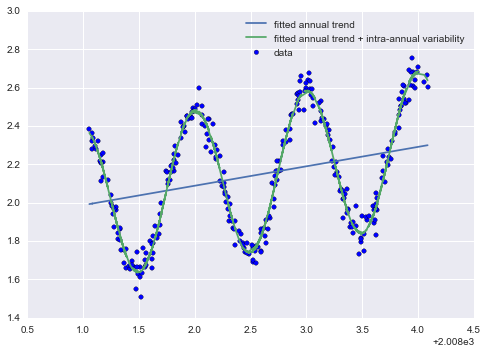

In [3]:
sns.set_context("notebook")
np.random.seed(seed=0)

intercept = 2.
trend = 0.1
variability = 0.4
noise = 0.05

x = np.arange(2009, 2012, 0.01)
x += np.random.random(size=x.size) * 0.1 
y = variability * np.cos(x * np.pi / 0.5) + trend * (x - x.min()) + intercept
y += np.random.normal(scale=noise, size=y.size)
w = np.ones_like(x)

res = fit_driftfourier(x, y, w, 2)

print("fitted trend (slope): {}".format(res[1]))
print("fitted intercept at xmin: {}".format(res[0]))
print("fitted fourier parameters: {}".format(res[2]))
print("std of residuals: {}".format(res[6]))

f_drift, f_fourier, f_driftfourier = res[3:6]

plt.scatter(x, y, label='data')
plt.plot(x, f_drift(x), label='fitted annual trend')
plt.plot(x, f_driftfourier(x),
         label='fitted annual trend + intra-annual variability')
plt.legend()

Statistical significance using bootstrap resampling: 2.5%, 50% and 97.5% percentiles for each fitted parameter and histogram of the distribution obtained for the annual trend (slope) and intercept estimates.

{'intercept': array([ 1.98152376,  1.99281233,  2.00459845]),
 'pfourier': array([[ 0.36480368,  0.37266487,  0.38059166],
       [-0.14720898, -0.13925057, -0.13075194],
       [-0.00928356, -0.00159154,  0.00640595],
       [-0.00456552,  0.00319257,  0.01144754]]),
 'slope': array([ 0.09453977,  0.10123101,  0.10780417])}


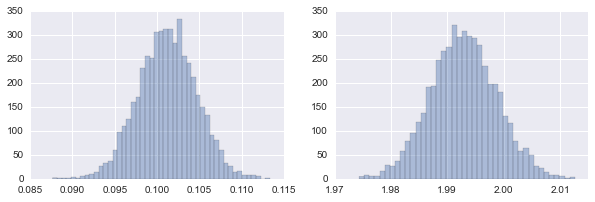

In [4]:
cf, intercept, slope, pfourier = cf_driftfourier(x, y, w, 2,
                                                 nboot=5000,
                                                 percentiles=(2.5, 50., 97.5))

pprint.pprint(cf)

f, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.distributions.distplot(slope, kde=False, ax=axes[0])
sns.distributions.distplot(intercept, kde=False, ax=axes[1])